In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, diff, integrate, simplify, Matrix, pi, lambdify

In [2]:
# === Variables ===
n = 4 #factor of saftey
Sy = 200 #yeild strength (in mpa)


# Define unknowns
Fx, Fy= symbols('Fx Fy')
Fz = 10340

#gravity
d_g = Matrix([0.85,0.03,1.15])
f_g = Matrix([0,0,-Fz])

#point B
d_b = Matrix([0,0,2.3])
f_b = Matrix([Fx,Fy,Fz])


In [3]:
#cross product
Mg = d_g.cross(f_g)
Mb = d_b.cross(f_b)

fx = Eq(Mg[0] + Mb[0], 0)
fy = Eq(Mg[1] + Mb[1], 0)
fz = Eq(Mg[2] + Mb[2], 0)

sol = solve((fx,fy),(Fx,Fy))
sol[Fz] = Fz
print("solution for forces", sol)

# Check if the solution contains all necessary keys
# Substituting forces
subs_dict = {Fx: -sol[Fx], Fy: -sol[Fy]}
fa = Matrix([sol[Fx], sol[Fy], Fz])



solution for forces {Fx: -3821.30434782609, Fy: -134.869565217391, 10340: 10340}


In [4]:
print(Mg, Mb,(fx), sol, fa)

Matrix([[-310.200000000000], [8789.00000000000], [0]]) Matrix([[-2.3*Fy], [2.3*Fx], [0]]) Eq(-2.3*Fy - 310.2, 0) {Fx: -3821.30434782609, Fy: -134.869565217391, 10340: 10340} Matrix([[-3821.30434782609], [-134.869565217391], [10340]])


In [5]:
#Reaction forces
# Forces acting on point A are equal and opposite to point B,
# each hinge is set to support the full weight of the door, as an extra measure of saftey and for redundancy.


In [6]:
#designing around the diameter of the pin, the diameter 'd' and length 'L' are the variables we are desinging around.
d, L = symbols('d L')

A = (pi/4)*(d**2) #area of the pin

I = (pi*(d**4))/64 #2nd moment of inertia

# ==== stresses acting on the pin ====
NormStress = Fz/A # normal stress, the stress acting vertically in the direction of the stress.

Pdimen = Matrix([d/2,d/2,L])
Mbend = Pdimen.cross(fa)

BndSX = (Mbend[0]*(d/2))/(I)
BndSY = (Mbend[1]*(d/2))/(I)

print(Mbend, BndSX, BndSY)

# === shear on the pin ===
# shear along the plane of the pin acts a stress tensor across the xy plane, the forces act perpendical to the xy plane
# the shear is therefore not a component in the x or y direction, but the resulatant of the magnitude of the forces acting in x&y

V = ((sol[Fx]**2) + (sol[Fy]**2))**0.5 #taking the magnitude of the forces in x&y
ShearS = V/(2*A) #shear is devided by twice the area for pins in a double shear configuration, the door acts like a large shear
TorsS = (4*V)/(3*pi*(d**2))

print(ShearS, TorsS)


Matrix([[134.869565217391*L + 5170*d], [-3821.30434782609*L - 5170*d], [1843.21739130435*d]]) 32*(134.869565217391*L + 5170*d)/(pi*d**3) 32*(-3821.30434782609*L - 5170*d)/(pi*d**3)
7647.36731649173/(pi*d**2) 5098.24487766115/(pi*d**2)


In [7]:
# === inplane stesses (von mise stress) ===
# the inplane stresses are converted into a scaler with which they can be compared with the yeild stregnth of materials. (eigen values of the stress tensor)
# this allows us to relate complex stresses to the stresses expirenaced by materials tested in a lab, and design around the failure point

Shear = (ShearS + TorsS)
vMs = ((BndSX**2) + BndSX*BndSY + (BndSY**2) + 3*(Shear**2))**0.5

print(vMs) #(N*m, in pa)
print(vMs.subs(sol))
vMsSol = vMs.subs(sol)
vMsSol = vMs.subs({Fx: sol[Fx], Fy: sol[Fy], Fz: Fz})

print(vMsSol)
print('\n',simplify(vMsSol))

165440.0*(0.0178058049779458/(pi**2*d**4) + (-3821.30434782609*L - 5170*d)*(134.869565217391*L + 5170*d)/(26728900*pi**2*d**6) + (-0.739130434782609*L - d)**2/(pi**2*d**6) + (0.0260869565217391*L + d)**2/(pi**2*d**6))**0.5
165440.0*(0.0178058049779458/(pi**2*d**4) + (-3821.30434782609*L - 5170*d)*(134.869565217391*L + 5170*d)/(26728900*pi**2*d**6) + (-0.739130434782609*L - d)**2/(pi**2*d**6) + (0.0260869565217391*L + d)**2/(pi**2*d**6))**0.5
165440.0*(0.0178058049779458/(pi**2*d**4) + (-3821.30434782609*L - 5170*d)*(134.869565217391*L + 5170*d)/(26728900*pi**2*d**6) + (-0.739130434782609*L - d)**2/(pi**2*d**6) + (0.0260869565217391*L + d)**2/(pi**2*d**6))**0.5

 166906.397392704*((0.518480699191789*L**2 + 0.751830445023772*L*d + d**2)/d**6)**0.5/pi**1.0


# Heatmap generation

**1. Von Mise Stress function:**

In [8]:
# the lambdify function converts the symbolic expression to a numerical function for plotting
vMs_func = lambdify((d, L), vMs.subs({Fx: sol[Fx], Fy: sol[Fy], Fz: Fz}), modules='numpy')

**2. Factor of safety**


In [9]:
Sy = 200e6  # Yield strength in Pascals (MPa -> Pa)
n = 4    # Factor of safety
stress_limit = Sy / n  # Maximum allowable von Mises stress


print("Stress limit (Pa):", stress_limit)

Stress limit (Pa): 50000000.0


In [10]:
# Generating the mesh grid with possible combinations for d and L:

d_vals = np.linspace(0.02, 0.10, 50)  # 20 mm to 10 cm
L_vals = np.linspace(0.05, 0.2, 50)    # 5 mm to 20 cm

# Mesh
D, L_grid = np.meshgrid(d_vals, L_vals)

# Calculate von Mises stress for each combination of d and L
vMs_vals = vMs_func(D, L_grid)

# Create mask for safe region (the safe threshold for von Mises stress)
safe_region = vMs_vals < stress_limit



/tmp/ipython-input-11-3606522456.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(D * 1000, L_grid * 1000, safe_region,  colors='green', linewidths=5, label='Safe Region') # Inside the contour is the safe region


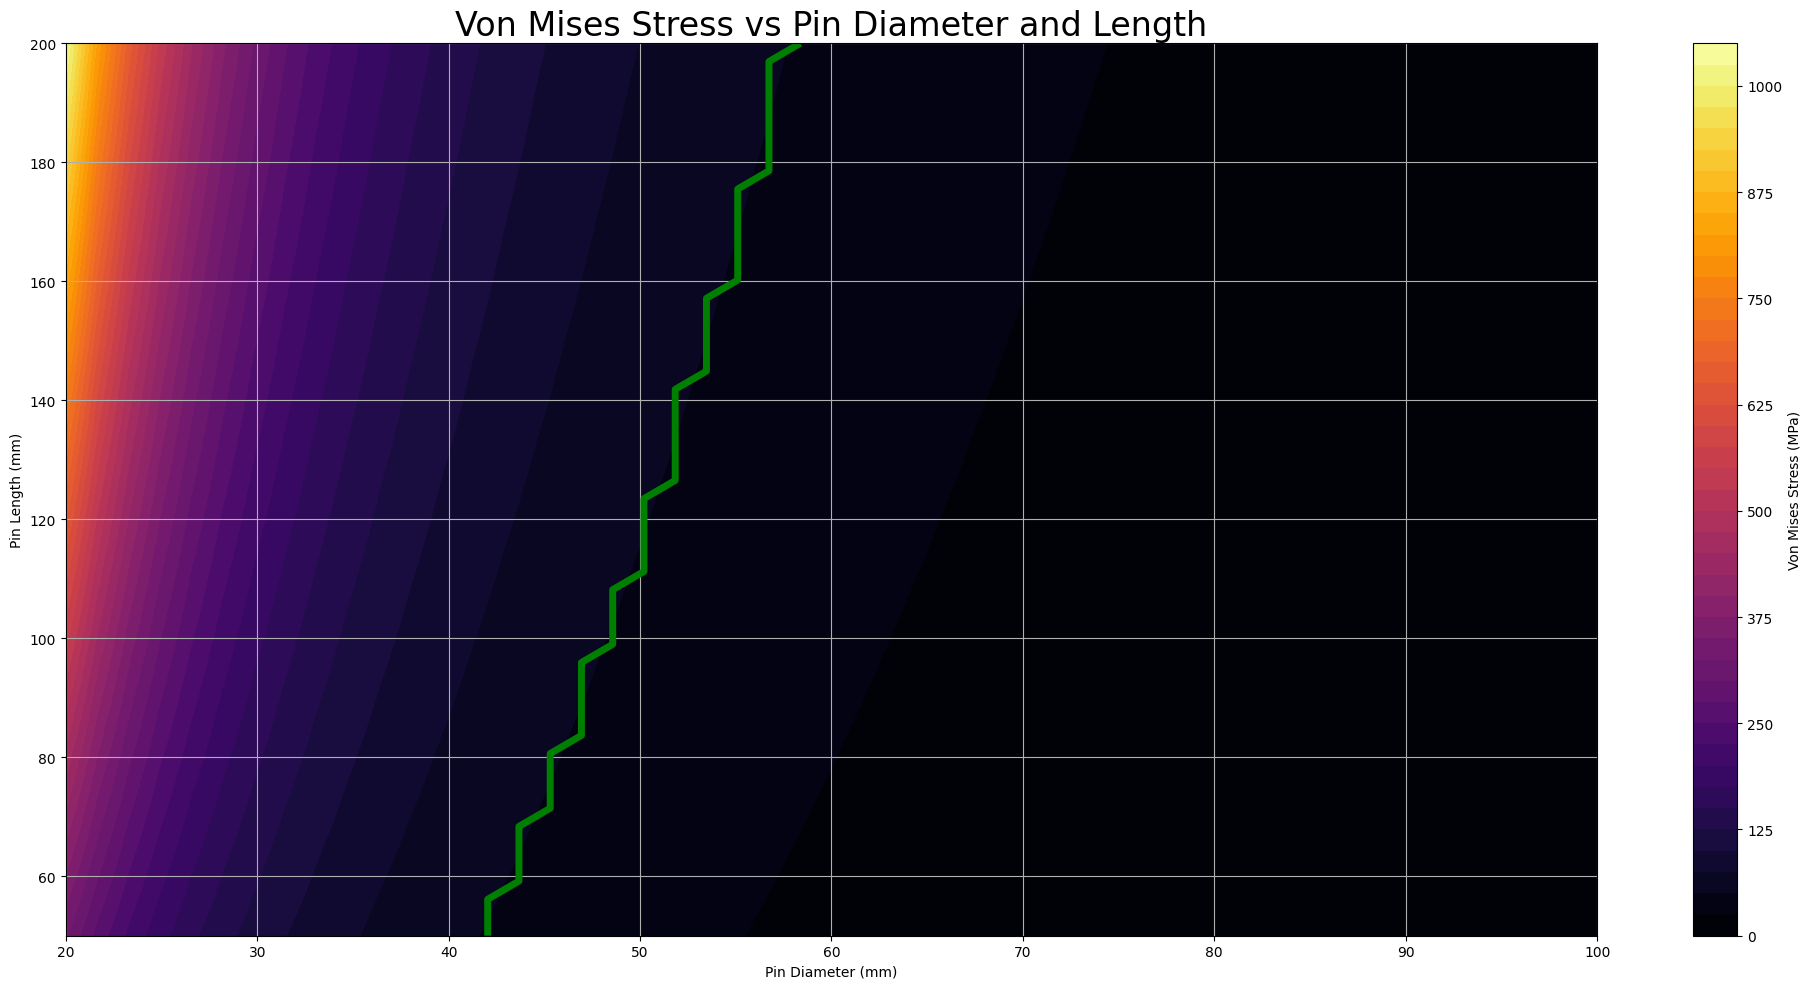

In [11]:
# Plotting
# Set up the plot size
plt.figure(figsize=(20, 10))
# Create contour plot for von Mises stress with the values converted to mm
contour = plt.contourf(D * 1000, L_grid * 1000, vMs_vals / 1e6, levels=50, cmap='inferno') # You can choose different colormaps like 'viridis', 'plasma', etc. For inferno,low stress is dark, high stress is bright
# This just adds a color bar
plt.colorbar(contour, label='Von Mises Stress (MPa)')
plt.contour(D * 1000, L_grid * 1000, safe_region,  colors='green', linewidths=5, label='Safe Region') # Inside the contour is the safe region
plt.title('Von Mises Stress vs Pin Diameter and Length', fontsize=24)
plt.xlabel('Pin Diameter (mm)')
plt.ylabel('Pin Length (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("Any safe values?", np.any(safe_region))
print("All safe?", np.all(safe_region))

Any safe values? True
All safe? False


In [13]:
# Convert D and L_grid to mm for display
D_mm = D * 1000
L_mm = L_grid * 1000

# Get indices of safe points
safe_indices = np.where(safe_region)

# Extract safe (d, L) combinations
safe_combinations = list(zip(D_mm[safe_indices], L_mm[safe_indices]))

    # Save these values to a file
with open('safe_combinations.txt', 'w') as f:
    for d_val, l_val in safe_combinations:
        f.write(f"Diameter: {d_val:.2f} mm, Length: {l_val:.2f} mm\n")


To make this interactive just pop the code to chatgpt and ask it to translate it from matplotlib to plotly or a different interactive plotting library

In [14]:
# Run this if you need to install plotly because you don't have it in your environment yet
!pip install plotly

In [15]:
# You might have to install nbformat too for plotly to work properly in Jupyter notebooks
#!pip install nbformat

In [16]:
import plotly.graph_objects as go

# Convert units for display: mm for d and L, MPa for stress
D_mm = D * 1000
L_mm = L_grid * 1000
vMs_mpa = vMs_vals / 1e6  # Convert stress to MPa

# Create Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    x=D_mm[0],             # Diameter (mm), 1D from meshgrid
    y=L_mm[:, 0],          # Length (mm), 1D from meshgrid
    z=vMs_mpa,             # Stress values in MPa
    colorscale='Inferno',
    colorbar=dict(title='Von Mises Stress (MPa)'),
    hovertemplate=
        'Diameter: %{x:.2f} mm<br>' +
        'Length: %{y:.2f} mm<br>' +
        'Stress: %{z:.2f} MPa<extra></extra>'
))

fig.update_layout(
    title='Von Mises Stress vs Pin Diameter and Length',
    xaxis_title='Pin Diameter (mm)',
    yaxis_title='Pin Length (mm)',
    width=1000,
    height=700
)

fig.show()
